# Simultaneous Calibration and Signal Fits for Different Numbers of Cal terms

**Steven Murray**
08/27/21

This short memo outlines simple tests performed to understand the impact of the choice of number of calibration terms used when simultaneously fitting for signal and calibration on semi-simulated data.

To provide a short recap: the idea here is to simultaneously fit both calibration data and field data where the model for the calibration sources is:

\begin{equation}
T_{\rm NS} Q_{\rm src} - c_{\rm src} T_{\rm src} = \mathbf{K}_{\rm src} \mathbf{T}_{\rm NW} - T_{\rm L} + \mathcal{N}_{\rm src},
\end{equation}

and the model for the field data is

$$ T_{\rm NS} Q_{\rm ant} - c_{\rm ant} T_{21} = \mathbf{K}_{\rm ant} \mathbf{T}_{\rm ant} - T_{\rm L} + c_{\rm ant}T_{\rm FG} + \mathcal{N}_{\rm ant}.$$

Here, the exact definition of each of the terms is unimportant, but not that all of the $T$'s except $T_{\rm src}$ are unknown models to be fit, and all other variables are measured. Everything on the RHS is linear in its parameters (i.e. the temperatures are linear polynomial/linlog models) and is marginalized analytically. 

The final point is that the assumed Gaussian noise in both cases is dominated by the variance of the measured $Q$ multiplied by $T_{\rm NS}^2$, i.e. it depends on the unknown model. 

To get the maximum likelihood parameters, the method is essentially to choose a set of parameters for the models on the LHS (i.e. $T_{\rm NS}$ and $T_{21}$), then solve the ML of all the parameters on the RHS with standard linear algebra, find the residual and $\chi^2$, and use that $\chi^2$ as the likelihood in a standard downhill-gradient solver. In the end, we have our ML parameters for $T_{\rm NS}$ and $T_{21}$, but can obtain the other linear parameters as well, if needed.

To test this code, we use simulated inputs. Now, it is important to use *realistic* simulated inputs. Therefore, we use an actual calibration observation (in this case 2015-09) to obtain data for $K_{\rm src}$ and $c_{\rm src}$. Note that the values we use here are the _smooth models_ of these values, not the noisy measured data. This makes them ideal (as if we had simulated them from scratch, with the correct assumptions for the above model -- namely that the $K$ and $c$ are essentially noiseless). 

The last (and most important) thing to simulate is $Q$. To do this, for the calibration sources, we use the calibration solutions from the same observation (i.e. the smooth polynomial models that provide a best fit to the real data) and use them to "decalibrate" the measured input temperature, $T_{\rm src}$ (which is, under this model, noiseless, as we "know" the exact input temperature). This gives us a noiseless model for $Q_{\rm src}$. To this, noise should be added, and we can do this in a number of ways (we build it up in increments).

As for $Q_{\rm ant}$, we do a similar thing: we choose some input model for $T_{21}$ and $T_{\rm FG}$, then decalibrate with the same polynomial models. 

Note that in all of this, we use the calibrated polynomials just to achieve a realistic input model -- it would not be at all inconsistent to change these models, since all the input mock data would be consistently simulated with whatever values were chosen (and the $K$ and $c$ do not at all depend on the noise wave temperatures). 
In fact, to make it easier to precisely compare the output model for $T_{\rm NS}$, we do in fact choose a slightly modelfied form for it that essentially uses round numbers for each of the coefficients. 

We test incrementally in a few stages:

1. Pure simulated $Q$ without any noise. This is actually a bit of a hack, because the likelihood depends on the assumed magnitude of the noise (it's not purely minimizing the RMS of residuals, but includes a term of the determinant of the covariance). When doing this test, we merely force the likelihood into a "minimize RMS" form. 
2. Small constant variance for both calibration and antenna inputs, added exactly as Gaussian noise to $Q$, and input as the variance to the likelihood.
3. For the calibration sources, using a variance derived from the measurements themselves (i.e. taking the variance over integrations). We use this (non-constant) variance to generate noise on $Q$, and supply the likelihood with this exact variance (so everything should be exactly consistent still, but with a more realistic level of noise).
4. Finally, instead of simulating $Q_{\rm src}$, use the actual measured $Q_{\rm src}$, and input the variance as the *estimated* variance of these measurements. This has a chance to be somewhat inconsistent, if the real measurements are non-Gaussian or correlated between frequencies. Furthermore, the $Q_{\rm ant}$ here is simulated still based on the input models, but we should note that those input *models* might not line up with the actual real gains perfectly, in which case the input data itself would not be entirely consistent.

### Import and Setup

In [1]:
from edges_cal import CalibrationObservation
from edges_analysis.analysis.calibrate import LabCalibration
import numpy as np
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.likelihoods import DataCalibrationLikelihood
from edges_cal.modelling import LinLog, Polynomial, UnitTransform
from scipy import stats
from yabf import ParamVec, run_map
from pathlib import Path
from edges_cal.simulate import simulate_qant_from_calobs
import matplotlib.pyplot as plt
import edges_cal as ec
import edges_io as eio
import edges_analysis as ea
import edges_estimate as ee

Here are the versions of the relevant packages used for this memo:

In [2]:
print("edges-io: ", eio.__version__)
print("edges-cal: ", ec.__version__)
print("edges-analysis: ", ea.__version__)
print("edges-estimate: ", ee.__version__)

edges-io:  2.5.4.dev6+g72be093
edges-cal:  3.4.0
edges-analysis:  2.1.1
edges-estimate:  1.0.0


For completeness, here is the input calibration observation we use as a reference:

In [3]:
def get_calobs(cterms=6, wterms=5):
    calobs = CalibrationObservation(
        "/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/", 
        f_low=50.0,
        f_high=100.0,
        run_num={"receiver_reading": 6},
        repeat_num=1,
        cterms=cterms,
        wterms=wterms,
        load_kwargs= {"t_load": 300, "t_load_ns": 350},
        load_spectra = {
            "hot_load": {"ignore_times_percent": 10},
            "ambient": {"ignore_times_percent": 7},
            "open": {"ignore_times_percent": 7},
            "short": {"ignore_times_percent": 7},
        },
        load_s11s = {"lna":{'n_terms': 11, 'model_type': 'polynomial'}}
    )

    labcal = LabCalibration(
        calobs=calobs, s11_files=sorted(Path('/data5/edges/data/S11_antenna/low_band/20160830_a/s11').glob('*.s1p'))
    )
    
    return calobs, labcal

In [4]:
calobs, labcal = get_calobs()

Define the input model for $T_{21}$:

In [5]:
eor = AbsorptionProfile(
    freqs=calobs.freq.freq, 
    params={
        "A": {'fiducial': 0.5, 'min': 0, 'max': 1.5, "ref": stats.norm(0.5, scale=0.01) },
        "w": {'fiducial': 15, 'min': 5, 'max': 25, "ref": stats.norm(15, scale=0.1)},
        "tau": {'fiducial': 5, 'min': 0, 'max': 20, "ref": stats.norm(5, scale=0.1)},
        "nu0": {'fiducial': 78, 'min': 60, 'max': 90, 'ref': stats.norm(78, scale=0.1)},
    }
)

And define the input model for $T_{FG}$:

In [6]:
fg = LinLog(n_terms=5, parameters=[2000, 10, -10, 5, -5])

Define a fiducial ideal model for $T_{\rm NS}$ (useful for precise comparisons of input vs output instead of using the measured model from the calibration observation):

In [7]:
def get_tns_model(calobs, ideal=True):
    if ideal:
        p = np.array([1575, -175, 70.0, -17.5, 7.0, -3.5])
    else:
        p = calobs.C1_poly.coeffs[::-1] * labcal.calobs.t_load_ns
        
    t_ns_model = Polynomial(parameters=p, transform=UnitTransform())

    t_ns_params = ParamVec(
        't_lns', length=len(p), 
        min=p - 100, 
        max=p + 100,
        ref=[stats.norm(v, scale=1.0) for v in p],
        fiducial=p
    )
    return t_ns_model, t_ns_params

Define a function to simulate the antenna 3-position ratio:

In [8]:
def sim_antenna_q(labcal, ideal_tns=True):
    calobs = labcal.calobs
    
    spec = fg(x=calobs.freq.freq) + eor()['eor_spectrum']
    
    tns_model, _ = get_tns_model(calobs, ideal=ideal_tns)
    scale_model = tns_model.with_params(tns_model.parameters/calobs.t_load_ns)
        
    return simulate_qant_from_calobs(
        calobs, ant_s11=labcal.antenna_s11, ant_temp=spec, 
        scale_model=scale_model
    )

Define a simple function to get a likelihood for given input choices:

In [9]:
def get_likelihood(labcal, qvar_ant, cal_noise, simulate=True, ideal_tns=True):
    calobs = labcal.calobs
    
    q = sim_antenna_q(labcal, ideal_tns=ideal_tns)
    
    if isinstance(qvar_ant, (int, float)):
        qvar_ant = qvar_ant * np.ones_like(labcal.calobs.freq.freq)
    
    q = q + np.random.normal(scale=qvar_ant)
    
    tns_model, tns_params = get_tns_model(calobs, ideal=ideal_tns)

    if ideal_tns:
        scale_model = Polynomial(parameters=np.array(tns_params.fiducial)/labcal.calobs.t_load_ns, transform=UnitTransform())
    else:
        scale_model = None

    return DataCalibrationLikelihood.from_labcal(
        labcal, 
        q_ant=q, 
        qvar_ant=qvar_ant, 
        fg_model=fg, 
        eor_components=(eor,),
        sim=simulate,
        scale_model=scale_model,
        t_ns_params=tns_params,
        cal_noise=cal_noise,
    )

And a function to view the results:

In [10]:
def view_results(lk, res_data, sim_tns=True, calobs=calobs, label=None, fig=None, ax=None, c=0):
    """Simple function to create a plot of input vs expected TNS and T21."""
    eorspec = lk.partial_linear_model.get_ctx(params=res_data.x)

    if fig is None:
        plot_input = True
        fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
    else:
        plot_input = False

    color = f"C{c}"
    nu = calobs.freq.freq

    tns_model, _ = get_tns_model(calobs, ideal=sim_tns)
    tns_model = tns_model(nu)
    
    if plot_input:
        ax[0, 0].plot(nu, tns_model, label='Input', color='k')
    
    ax[0, 0].plot(nu, eorspec['tns'], label='Estimated' + (' '+label if label else ''), color=color)
    
    ax[1, 0].plot(nu,eorspec['tns'] - tns_model, label=r"$\Delta T_{\rm NS}$" if plot_input else None, color=color)
    ax[1, 0].plot(nu,(eorspec['tns'] - tns_model)*lk.data['q']['ant'], ls='--', color=color, label=r"$\Delta T_{\rm NS} Q_{\rm ant}$" if plot_input else None)
    
    ax[0, 0].set_title(r"$T_{\rm NS}$")
    ax[0, 0].set_ylabel("Temperature [K]")
    
    if plot_input:
        ax[0, 1].plot(nu,eor()['eor_spectrum'], color='k')
    
    ax[0, 1].plot(nu,eorspec['eor_spectrum'])
    ax[0, 1].set_title(r"$T_{21}$")
    delta = eorspec['eor_spectrum'] - eor()['eor_spectrum']
    ax[1, 1].plot(nu, delta, color=color, label=f"Max $\Delta = {np.max(np.abs(delta))*1000:1.2e}$mK")
    ax[1, 0].set_ylabel("Difference [K]")
            
    ax[1, 0].set_xlabel("Frequency")
    ax[1, 1].set_xlabel("Frequency")
    
    ax[0, 0].legend()
    ax[1, 0].legend()
    ax[1,1].legend()
    
    return fig, ax

## Test 1: No Noise

See the above list for the details of the simulation.

In [30]:
lk = get_likelihood(labcal, qvar_ant=0, cal_noise=0.0, simulate=True, ideal_tns=True)

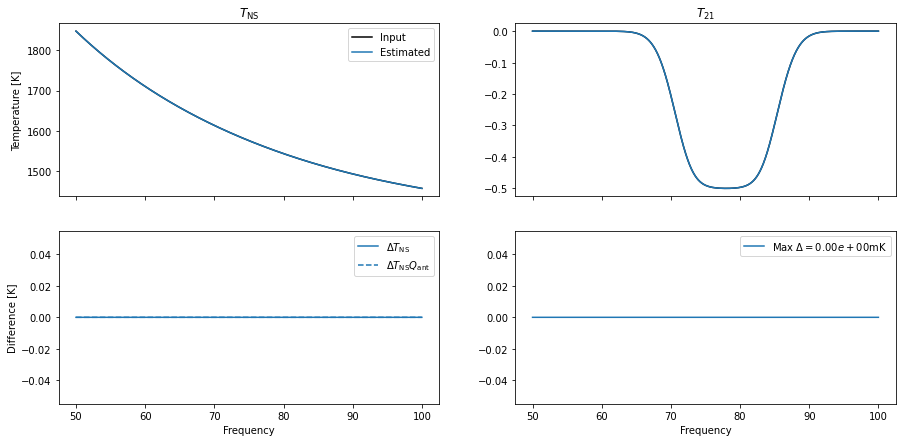

In [31]:
res = run_map(lk.partial_linear_model)
view_results(lk, res);

**Figure 1** | Results of fitting to simulated data without any noise. The results are perfect to machine precision.

## Test 2: Small Constant Noise

In [32]:
lk = get_likelihood(labcal, qvar_ant=1e-10, cal_noise=1e-10, simulate=True, ideal_tns=True)

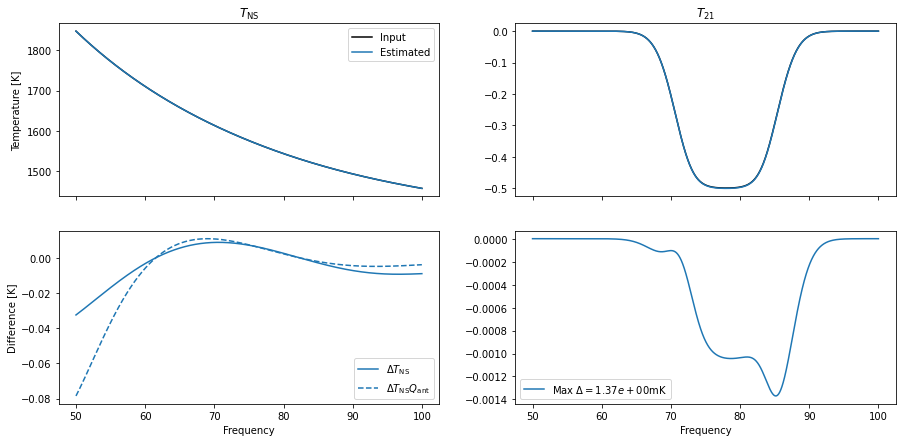

In [33]:
res = run_map(lk.partial_linear_model)
view_results(lk, res);

**Figure 2** | Again, comparing $T_{\rm NS}$ and $T_{21}$ inputs vs. outputs, this time with noise in the simulation. While the difference in $T_{\rm NS}$ is around 10mK, it is still rather smooth, and the effect on $T_{\rm 21}$ is sub-mK.

## Test 3: Realistic Non-Constant Noise

In this case, setting `cal_noise='data'` means that we use the intrinsic measured noise values of the calibration observation. We still use a constant small noise for the antenna data.

In [34]:
lk = get_likelihood(labcal, qvar_ant=1e-10, cal_noise='data', simulate=True, ideal_tns=True)

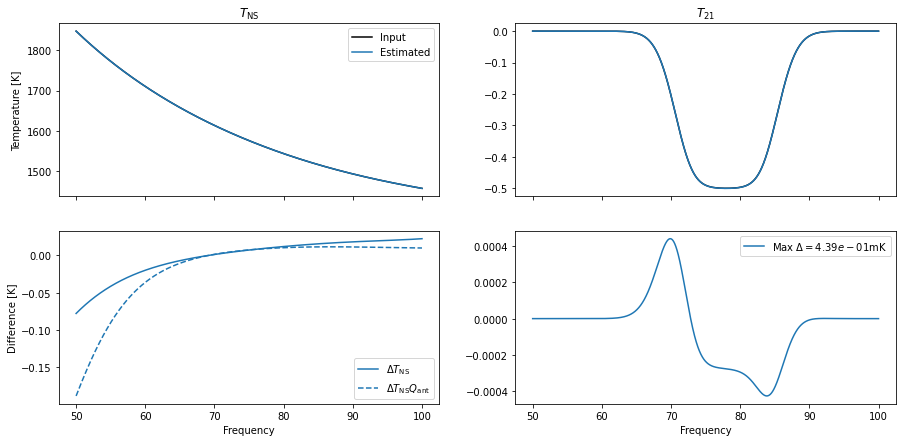

In [35]:
res = run_map(lk.partial_linear_model)
view_results(lk, res);

**Figure 3** | The same as Figs 1+2, but this time for non-constant noise (and larger amplitude noise). The estimate of $T_{\rm 21}$ is now off by 2.5mK, but this is still very good.

## Test 4: Measured Calibration Q, Simulated Antenna

As mentioned in the introduction, this test is slightly inconsistent, at least if the initial estimated calibration parameters are different to the actual gains -- or even if they are different to the final estimated gains.

In [36]:
lk = get_likelihood(labcal, qvar_ant=1e-10, cal_noise='data', simulate=False, ideal_tns=False)

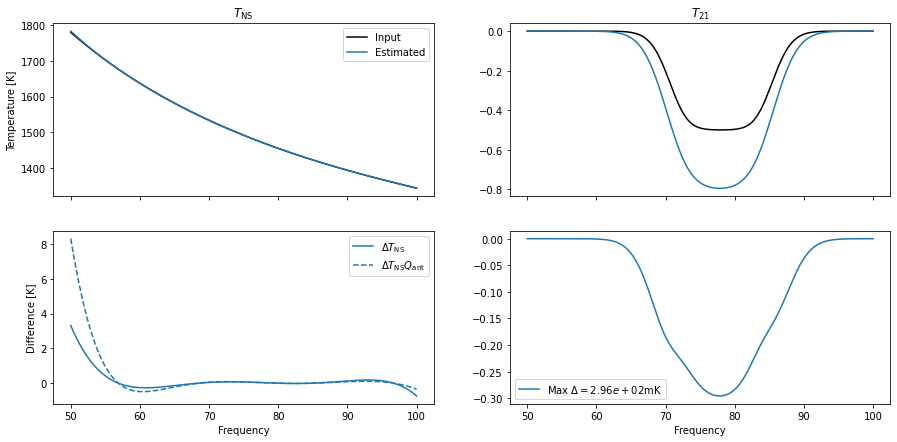

In [37]:
res = run_map(lk.partial_linear_model)
view_results(lk, res, sim_tns=False);

**Figure 4** | The result of attempting to simultaneously fit a "decalibrated" input sky model with _real_ calibration data. The inconsistency of the decalibration being performed with a non-true calibration solution has quite a significant impact on estimation of both $T_{\rm NS}$ and $T_{21}$.

## Test 5: Increasing Number of calibration terms

The most obvious reason that Test 4 didn't work is that the initial estimated calibration wasn't accurate. To make it more accurate, we could ostensibly increase the number of terms in the solution. 

/data4/smurray/Projects/radio/EOR/Edges/edges_estimate/src/edges_estimate/likelihoods.py:414: RuntimeWarning: invalid value encountered in log
  logdetCinv = np.log(np.linalg.det((basis / var).dot(basis.T)))
/data4/smurray/Projects/radio/EOR/Edges/edges_estimate/src/edges_estimate/likelihoods.py:414: RuntimeWarning: invalid value encountered in log
  logdetCinv = np.log(np.linalg.det((basis / var).dot(basis.T)))
/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/data4/smurray/Projects/radio/EOR/Edges/edges_estimate/src/edges_estimate/likelihoods.py:414: RuntimeWarning: invalid value encountered in log
  logdetCinv = np.log(np.linalg.det((basis / var).dot(basis.T)))


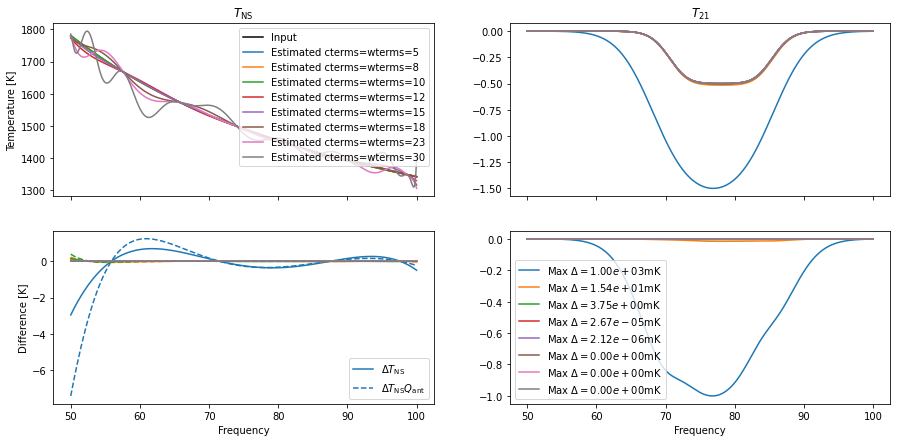

In [38]:
fig, ax = None, None

for i, terms in enumerate([5, 8, 10, 12, 15, 18, 23, 30]):
    calobs_, labcal_ = get_calobs(cterms=terms, wterms=terms)
    lk = get_likelihood(labcal_, qvar_ant=1e-8, cal_noise='data', simulate=False, ideal_tns=False)
    res = run_map(lk.partial_linear_model)
    fig, ax = view_results(lk, res, sim_tns=False, fig=fig, ax=ax, label=f'cterms=wterms={terms}', calobs=labcal_.calobs, c=i);

**Figure 5** | Resulting estimates for $T_{21}$ for a range of input number of terms (keeping cterms and wterms equal). We see that the estimate of $T_{21}$ gets significantly better as we add more terms, suggesting that the underlying model of calibration is better matched. However, The model for $T_{\rm NS}$ becomes significantly more structured for the higher numbers of terms, which may not be a great representation of reality. It is possible that more terms may be required for _some_ of the calibration polynomials, but not others. 

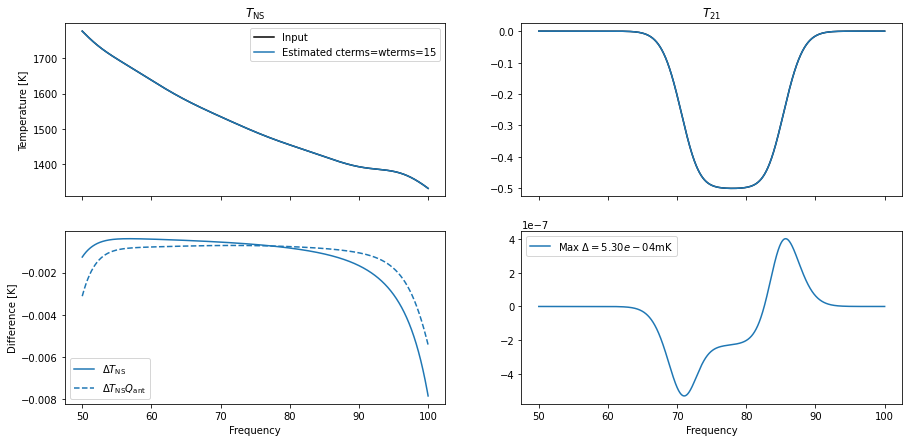

In [11]:
fig, ax = None, None

for i, terms in enumerate([15]):
    calobs_, labcal_ = get_calobs(cterms=terms, wterms=terms)
    lk = get_likelihood(labcal_, qvar_ant=1e-8, cal_noise='data', simulate=False, ideal_tns=False)
    res = run_map(lk.partial_linear_model)
    fig, ax = view_results(lk, res, sim_tns=False, fig=fig, ax=ax, label=f'cterms=wterms={terms}', calobs=labcal_.calobs, c=i);